# Similarity Network Fusion

This notebook is a demonstration of how to integrate select modalities for training with MOGDx

In [5]:
# Importing the libraries

import pandas as pd
import numpy as np
import itertools
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from palettable import wesanderson
import sys
sys.path.insert(0 , './../MAIN/')
from utils import *
import preprocess_functions

In [2]:
# Specify modalities and parameters

modalities = ['mRNA'  ,'RPPA']
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

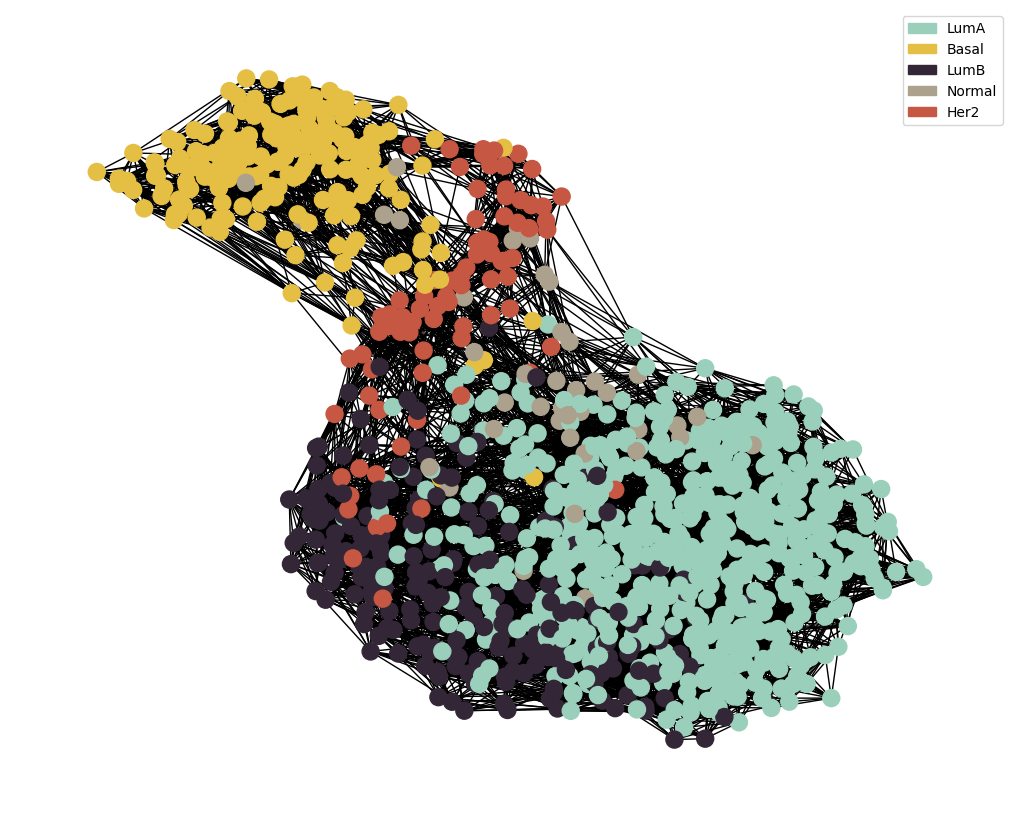

In [4]:
# Load networks and perform SNF

# Load networks
all_graphs = {}
all_idx = []

for i , mod in enumerate(modalities) : 
    with open(f'./../../../../data/raw/{mod}_processed.pkl', 'rb') as file:
        loaded_data = pickle.load(file)

    if i == 0 : 
        datMeta = loaded_data['datMeta'].reset_index()
    else : 
        datMeta = pd.merge(datMeta , loaded_data['datMeta'].reset_index() , how = 'outer'  , on = [index_col , target])

    all_graphs[mod] =  nx.read_graphml(f'./../../../../data/Networks/{mod}_graph.graphml')
    all_idx.extend(list(all_graphs[mod].nodes))

# Merge metadata and create list of ids        
datMeta = datMeta.set_index(index_col)
all_idx = list(set(all_idx))

full_graphs = []

# Create network for each modality including patients wtihout data
for mod , graph in all_graphs.items() : 
    full_graph = pd.DataFrame(data = np.zeros((len(all_idx) , len(all_idx))) , index=all_idx , columns=all_idx)
    graph = nx.to_pandas_adjacency(graph)
    full_graph.loc[graph.index , graph.index] = graph.values
    
    full_graphs.append(full_graph)

#  Perform SNF
adj_snf = preprocess_functions.SNF(full_graphs , K=15 , t=10)

node_labels = pd.Series(adj_snf.index) 

node_colour = datMeta.loc[adj_snf.index][target].astype('category').cat.set_categories(wesanderson.FantasticFox2_5.hex_colors , rename=True)

G  = preprocess_functions.plot_knn_network(adj_snf , 15 , datMeta.loc[adj_snf.index][target] ,
                                                       node_colours=node_colour , node_size=150)
snf_name = '_'.join(modalities)

nx.write_graphml(G, f'./../../../../data/Networks/{snf_name}_graph.graphml')